## Explore RobInGas Data

We are going to load the RobInGas data and visualize the following data samples:
- RGB images
- Terrain heightmaps

### Load RobInGas Data

We inherit from the `monoforce.datasets.robingas.RobinGas` dataset to load only the RGB images and the terrain heightmap.

In [1]:
from monoforce.datasets.robingas import RobinGas

class Dataset(RobinGas):
    """
    RobInGas dataset for training terrain properties prediction from RGB images.
    
    Args:
        path (str): Path to the RobInGas data sequence.
        lss_cfg (dict): Configuration specific to robot sensors (see the LSS [1] paper for more details).
        is_train (bool): If True, the dataset is used for training.
        
    References:
        [1] Jonah Philion, Sanja Fidler, Lift, Splat, Shoot: Encoding Images From Arbitrary
            Camera Rigs by Implicitly Unprojecting to 3D,
            https://arxiv.org/abs/2008.05711
    """
    def __init__(self, path, lss_cfg, is_train=True,):
        super(Dataset, self).__init__(path, lss_cfg, is_train=is_train)

    def get_sample(self, i):
        """
        Get a sample from the dataset.
        Args:
            i (int): Index of the sample.
        Returns:
            tuple: Tuple containing the RGB images and the terrain heightmap.
        """
        imgs = self.get_images_data(i)[0]
        terrain = self.get_terrain_height_map(i)
        
        return imgs, terrain

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Load a Sequence of the RobInGas Data

We load a sequence of the RobInGas data for a Specific Robot (e.g., Husky ORU)

In [2]:
import os
from monoforce.utils import read_yaml
from monoforce.datasets.robingas import robingas_seq_paths

# as data sequence is specific to the robot, we need to load the correct configuration
robot = 'husky_oru'
lss_cfg_path = f'../config/lss_cfg_{robot}.yaml'
lss_cfg = read_yaml(lss_cfg_path)

# load the last sequence of the robot data
seq_path = robingas_seq_paths[robot][-1]
if not os.path.exists(seq_path):
    print(f'{seq_path} does not exist. Please download the RobInGas data.')
    raise FileNotFoundError(f'{seq_path} does not exist')

print('Loading RobInGas data from:', os.path.basename(seq_path))
ds = Dataset(seq_path, lss_cfg)
print('Number of data samples in the sequence:', len(ds))

Loading RobInGas data from: radarize_2024-06-12-10-06-11_0
Number of data samples in the sequence: 4133


### Visualize a Sample of the RobInGas Data

In [3]:
# get a sample from the dataset
i = 52  # np.random.randint(len(ds))
print('Sample index:', i)
imgs, terrain = ds[i]
print('RGB images shape:', imgs.shape)  # (N, C, H, W), where N is the number of cameras
print('Terrain heightmap shape:', terrain.shape)  # (2, H, W), where 2 is the heightmap and the mask of the labeled area

Sample index: 52
RGB images shape: torch.Size([1, 3, 256, 416])
Terrain heightmap shape: torch.Size([2, 128, 128])


Height map grid resolution [m]: 0.1
Height map grid size: 128 128


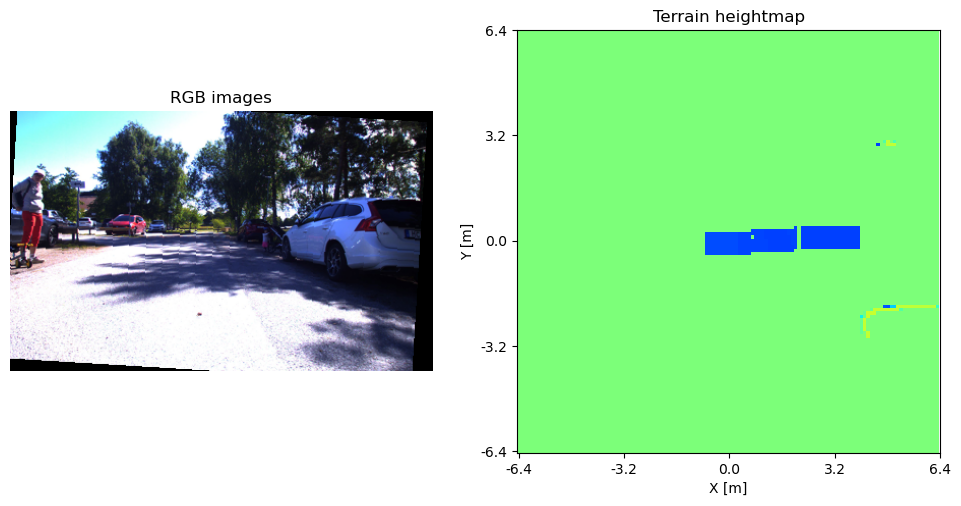

In [4]:
# visualize the RGB images and the terrain heightmap
import numpy as np
import matplotlib.pyplot as plt
from monoforce.models.terrain_encoder.utils import denormalize_img
%matplotlib inline

grid_res = lss_cfg['grid_conf']['xbound'][2]
H, W = terrain.shape[1:]
print('Height map grid resolution [m]:', grid_res)
print('Height map grid size:', H, W)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
img_vis = denormalize_img(imgs[0])
axs[0].imshow(img_vis)
axs[0].set_title('RGB images')
axs[0].axis('off')
    
axs[1].imshow(terrain[0].T, cmap='jet', vmin=-1, vmax=1, origin='lower')
axs[1].set_title('Terrain heightmap')
axs[1].set_xlabel('X [m]')
axs[1].set_ylabel('Y [m]')

# set x and y ticks
x_ticks = np.linspace(-H // 2 * grid_res, H // 2 * grid_res, 5)
y_ticks = np.linspace(-W // 2 * grid_res, W // 2 * grid_res, 5)
axs[1].set_xticks(np.linspace(0, W, len(x_ticks)))
axs[1].set_xticklabels([f'{x:.1f}' for x in x_ticks])
axs[1].set_yticks(np.linspace(0, H, len(y_ticks)))
axs[1].set_yticklabels([f'{y:.1f}' for y in y_ticks]);

### (Optional): Visualize the Mask of the Labeled Area and Robot's Trajectory

Robot poses shape: (10, 4, 4)


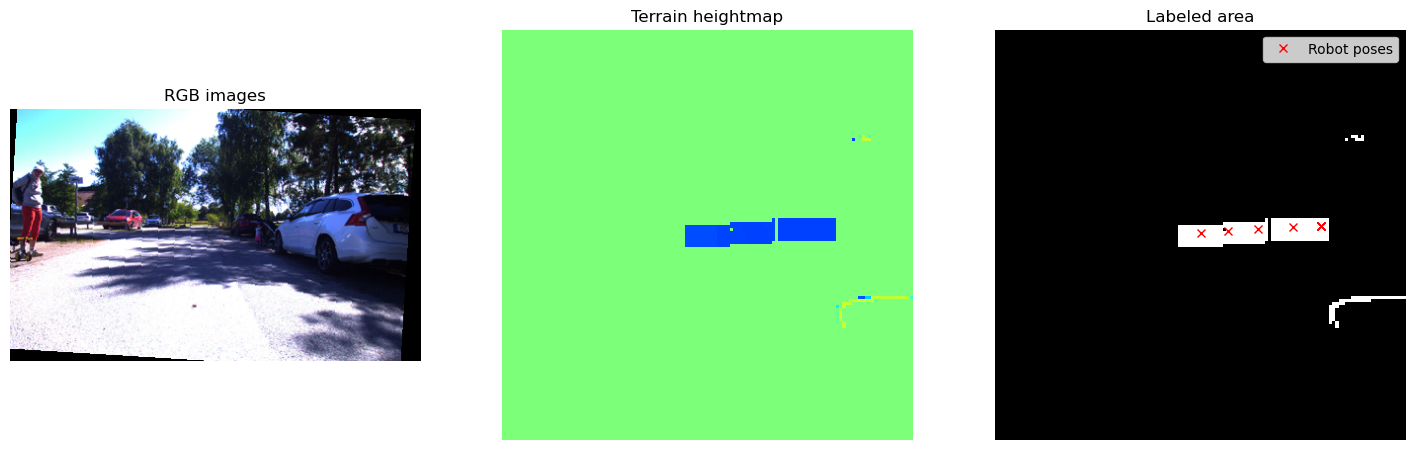

In [5]:
# let's additionally visualize the mask of the labeled area and robot's trajectory
poses = ds.get_traj(i)['poses']
print('Robot poses shape:', poses.shape)  # (N, 4, 4), where N is the number of poses

x_grid = poses[:, 0, 3] / grid_res + H // 2
y_grid = poses[:, 1, 3] / grid_res + W // 2

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
img_vis = denormalize_img(imgs[0])
axs[0].imshow(img_vis)
axs[0].set_title('RGB images')
axs[0].axis('off')

axs[1].imshow(terrain[0].T, cmap='jet', vmin=-1, vmax=1, origin='lower')
axs[1].set_title('Terrain heightmap')
axs[1].axis('off')

axs[2].imshow(terrain[1].T, cmap='gray', origin='lower')
axs[2].plot(x_grid, y_grid, 'rx', label='Robot poses')
axs[2].set_title('Labeled area')
axs[2].axis('off')
plt.legend();